# MAML

In [6]:
import  torch
from    torch import nn
from    torch import optim
from    torch.nn import functional as F
from    torch.utils.data import TensorDataset, DataLoader
from    torch import optim
import  numpy as np
from    copy import deepcopy
import  torch
from    torch import nn
from    torch.nn import functional as F
import  numpy as np
import  torch, os
import  scipy.stats
from    torch.utils.data import DataLoader
from    torch.optim import lr_scheduler
import  random, sys, pickle
import  argparse
import os
import torch
from torch.utils.data import Dataset
from torchvision.transforms import transforms
import numpy as np
import collections
from PIL import Image
import csv
import random
import matplotlib.pyplot as plt
%matplotlib inline  

# MINI ImageNet Data

Download Mini ImageNet Dataset: https://drive.google.com/file/d/1HkgrkAwukzEZA0TpO7010PkAOREb2Nuk/view


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shuffle DB :train, b:10, 5-way, 1-shot, 1-query, resize:168


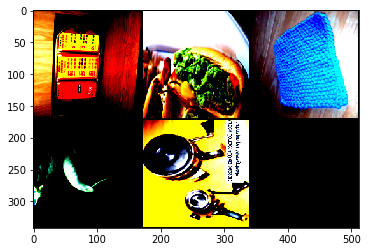

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


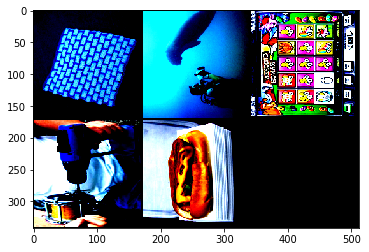

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


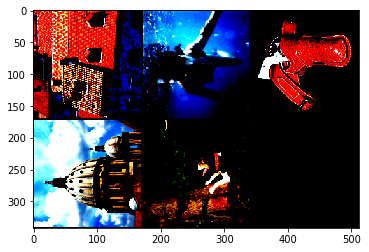

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


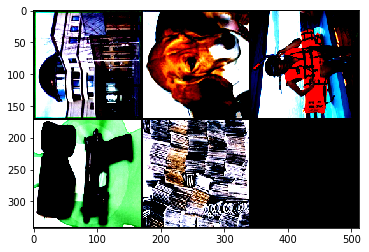

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


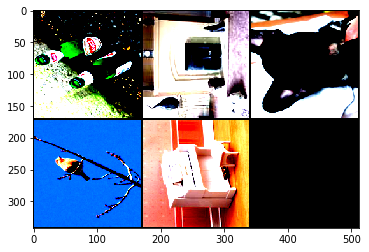

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


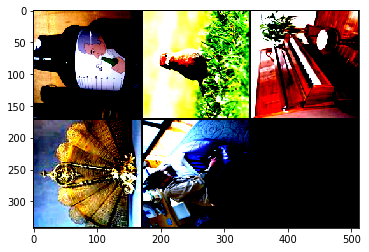

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


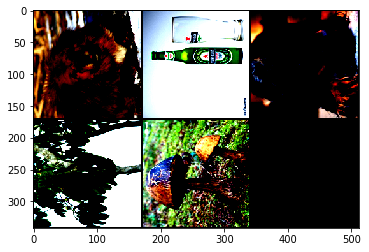

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


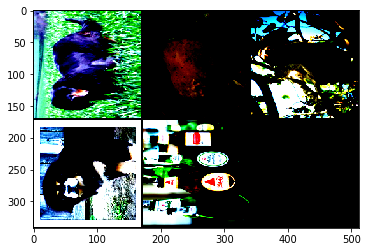

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


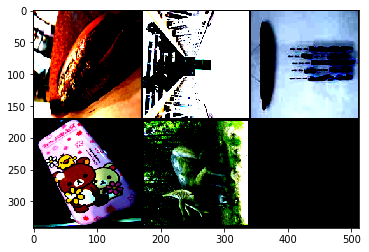

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


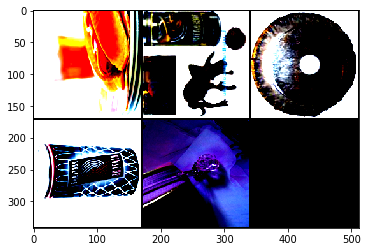

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


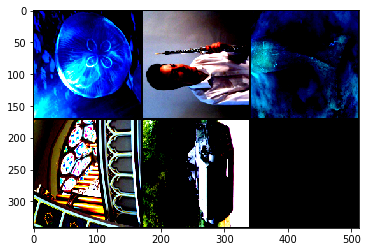

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


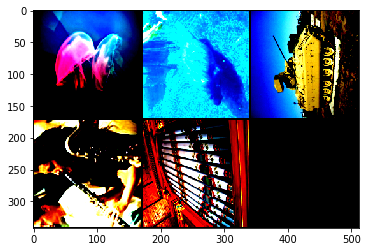

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


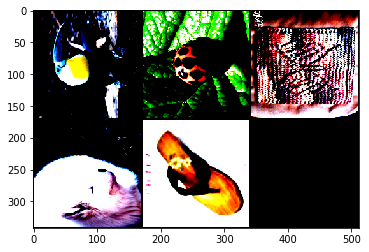

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


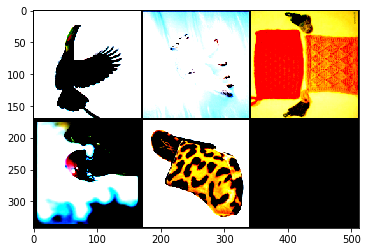

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


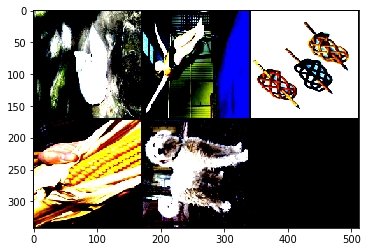

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


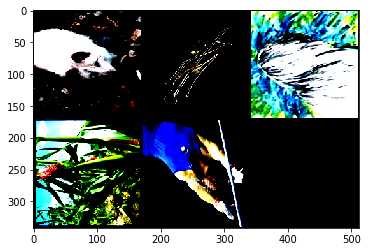

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


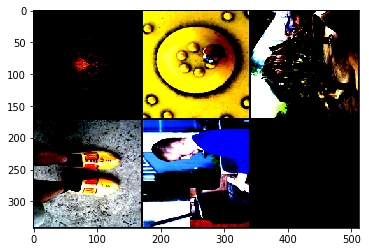

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


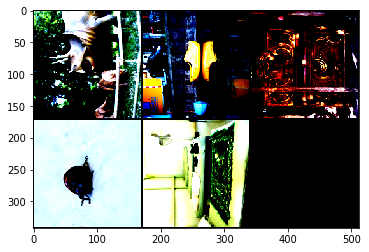

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


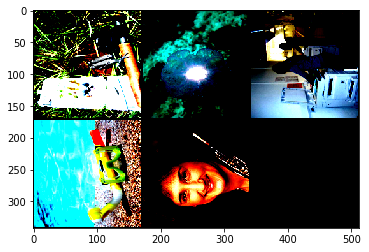

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


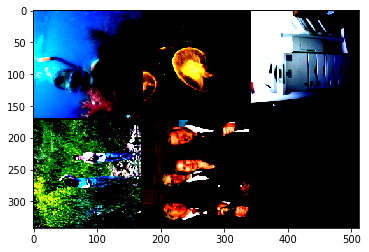

In [7]:
class MiniImagenet(Dataset):
    """
    put mini-imagenet files as :
    root :
        |- images/*.jpg includes all imgeas
        |- train.csv
        |- test.csv
        |- val.csv
    NOTICE: meta-learning is different from general supervised learning, especially the concept of batch and set.
    batch: contains several sets
    sets: conains n_way * k_shot for meta-train set, n_way * n_query for meta-test set.
    """

    def __init__(self, root, mode, batchsz, n_way, k_shot, k_query, resize, startidx=0):
        """
        :param root: root path of mini-imagenet
        :param mode: train, val or test
        :param batchsz: batch size of sets, not batch of imgs
        :param n_way:
        :param k_shot:
        :param k_query: num of qeruy imgs per class
        :param resize: resize to
        :param startidx: start to index label from startidx
        """

        self.batchsz = batchsz  # batch of set, not batch of imgs
        self.n_way = n_way  # n-way
        self.k_shot = k_shot  # k-shot
        self.k_query = k_query  # for evaluation
        self.setsz = self.n_way * self.k_shot  # num of samples per set
        self.querysz = self.n_way * self.k_query  # number of samples per set for evaluation
        self.resize = resize  # resize to
        self.startidx = startidx  # index label not from 0, but from startidx
        print('shuffle DB :%s, b:%d, %d-way, %d-shot, %d-query, resize:%d' % (
        mode, batchsz, n_way, k_shot, k_query, resize))

        if mode == 'train':
            self.transform = transforms.Compose([lambda x: Image.open(x).convert('RGB'),
                                                 transforms.Resize((self.resize, self.resize)),
                                                 # transforms.RandomHorizontalFlip(),
                                                 # transforms.RandomRotation(5),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                                 ])
        else:
            self.transform = transforms.Compose([lambda x: Image.open(x).convert('RGB'),
                                                 transforms.Resize((self.resize, self.resize)),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                                 ])

        self.path = os.path.join(root, 'images')  # image path
        csvdata = self.loadCSV(os.path.join(root, mode + '.csv'))  # csv path
        self.data = []
        self.img2label = {}
        for i, (k, v) in enumerate(csvdata.items()):
            self.data.append(v)  # [[img1, img2, ...], [img111, ...]]
            self.img2label[k] = i + self.startidx  # {"img_name[:9]":label}
        self.cls_num = len(self.data)

        self.create_batch(self.batchsz)

    def loadCSV(self, csvf):
        """
        return a dict saving the information of csv
        :param splitFile: csv file name
        :return: {label:[file1, file2 ...]}
        """
        dictLabels = {}
        with open(csvf) as csvfile:
            csvreader = csv.reader(csvfile, delimiter=',')
            next(csvreader, None)  # skip (filename, label)
            for i, row in enumerate(csvreader):
                filename = row[0]
                label = row[1]
                # append filename to current label
                if label in dictLabels.keys():
                    dictLabels[label].append(filename)
                else:
                    dictLabels[label] = [filename]
        return dictLabels

    def create_batch(self, batchsz):
        """
        create batch for meta-learning.
        ×episode× here means batch, and it means how many sets we want to retain.
        :param episodes: batch size
        :return:
        """
        self.support_x_batch = []  # support set batch
        self.query_x_batch = []  # query set batch
        for b in range(batchsz):  # for each batch
            # 1.select n_way classes randomly
            selected_cls = np.random.choice(self.cls_num, self.n_way, False)  # no duplicate
            np.random.shuffle(selected_cls)
            support_x = []
            query_x = []
            for cls in selected_cls:
                # 2. select k_shot + k_query for each class
                selected_imgs_idx = np.random.choice(len(self.data[cls]), self.k_shot + self.k_query, False)
                np.random.shuffle(selected_imgs_idx)
                indexDtrain = np.array(selected_imgs_idx[:self.k_shot])  # idx for Dtrain
                indexDtest = np.array(selected_imgs_idx[self.k_shot:])  # idx for Dtest
                support_x.append(
                    np.array(self.data[cls])[indexDtrain].tolist())  # get all images filename for current Dtrain
                query_x.append(np.array(self.data[cls])[indexDtest].tolist())

            # shuffle the correponding relation between support set and query set
            random.shuffle(support_x)
            random.shuffle(query_x)

            self.support_x_batch.append(support_x)  # append set to current sets
            self.query_x_batch.append(query_x)  # append sets to current sets

    def __getitem__(self, index):
        """
        index means index of sets, 0<= index <= batchsz-1
        :param index:
        :return:
        """
        # [setsz, 3, resize, resize]
        support_x = torch.FloatTensor(self.setsz, 3, self.resize, self.resize)
        # [setsz]
        support_y = np.zeros((self.setsz), dtype=np.int)
        # [querysz, 3, resize, resize]
        query_x = torch.FloatTensor(self.querysz, 3, self.resize, self.resize)
        # [querysz]
        query_y = np.zeros((self.querysz), dtype=np.int)

        flatten_support_x = [os.path.join(self.path, item)
                             for sublist in self.support_x_batch[index] for item in sublist]
        support_y = np.array(
            [self.img2label[item[:9]]  # filename:n0153282900000005.jpg, the first 9 characters treated as label
             for sublist in self.support_x_batch[index] for item in sublist]).astype(np.int32)

        flatten_query_x = [os.path.join(self.path, item)
                           for sublist in self.query_x_batch[index] for item in sublist]
        query_y = np.array([self.img2label[item[:9]]
                            for sublist in self.query_x_batch[index] for item in sublist]).astype(np.int32)

        # print('global:', support_y, query_y)
        # support_y: [setsz]
        # query_y: [querysz]
        # unique: [n-way], sorted
        unique = np.unique(support_y)
        random.shuffle(unique)
        # relative means the label ranges from 0 to n-way
        support_y_relative = np.zeros(self.setsz)
        query_y_relative = np.zeros(self.querysz)
        for idx, l in enumerate(unique):
            support_y_relative[support_y == l] = idx
            query_y_relative[query_y == l] = idx

        # print('relative:', support_y_relative, query_y_relative)

        for i, path in enumerate(flatten_support_x):
            support_x[i] = self.transform(path)

        for i, path in enumerate(flatten_query_x):
            query_x[i] = self.transform(path)
        # print(support_set_y)
        # return support_x, torch.LongTensor(support_y), query_x, torch.LongTensor(query_y)

        return support_x, torch.LongTensor(support_y_relative), query_x, torch.LongTensor(query_y_relative)

    def __len__(self):
        # as we have built up to batchsz of sets, you can sample some small batch size of sets.
        return self.batchsz


if __name__ == '__main__':
    # the following episode is to view one set of images via tensorboard.
    from torchvision.utils import make_grid
    from matplotlib import pyplot as plt
    from tensorboardX import SummaryWriter
    import time

    plt.ion()

    tb = SummaryWriter('runs', 'mini-imagenet')
    mini = MiniImagenet('./mini-imagenet/', mode='train', n_way=5, k_shot=1, k_query=1, batchsz=10, resize=168)

    for i, set_ in enumerate(mini):
        # support_x: [k_shot*n_way, 3, 84, 84]
        support_x, support_y, query_x, query_y = set_

        support_x = make_grid(support_x, nrow=2)
        query_x = make_grid(query_x, nrow=2)

        plt.figure(1)
        plt.imshow(support_x.transpose(2, 0).numpy())
        plt.pause(0.5)
        plt.figure(2)
        plt.imshow(query_x.transpose(2, 0).numpy())
        plt.pause(0.5)

        tb.add_image('support_x', support_x)
        tb.add_image('query_x', query_x)

        time.sleep(5)

    tb.close()

# Learner Code

In [8]:
class Learner(nn.Module):
    """
    """

    def __init__(self, config, imgc, imgsz):
        """
        :param config: network config file, type:list of (string, list)
        :param imgc: 1 or 3
        :param imgsz:  28 or 84
        """
        super(Learner, self).__init__()


        self.config = config

        # this dict contains all tensors needed to be optimized
        self.vars = nn.ParameterList()
        # running_mean and running_var
        self.vars_bn = nn.ParameterList()

        for i, (name, param) in enumerate(self.config):
            if name is 'conv2d':
                # [ch_out, ch_in, kernelsz, kernelsz]
                w = nn.Parameter(torch.ones(*param[:4]))
                # gain=1 according to cbfin's implementation
                torch.nn.init.kaiming_normal_(w)
                self.vars.append(w)
                # [ch_out]
                self.vars.append(nn.Parameter(torch.zeros(param[0])))

            elif name is 'convt2d':
                # [ch_in, ch_out, kernelsz, kernelsz, stride, padding]
                w = nn.Parameter(torch.ones(*param[:4]))
                # gain=1 according to cbfin's implementation
                torch.nn.init.kaiming_normal_(w)
                self.vars.append(w)
                # [ch_in, ch_out]
                self.vars.append(nn.Parameter(torch.zeros(param[1])))

            elif name is 'linear':
                # [ch_out, ch_in]
                w = nn.Parameter(torch.ones(*param))
                # gain=1 according to cbfinn's implementation
                torch.nn.init.kaiming_normal_(w)
                self.vars.append(w)
                # [ch_out]
                self.vars.append(nn.Parameter(torch.zeros(param[0])))

            elif name is 'bn':
                # [ch_out]
                w = nn.Parameter(torch.ones(param[0]))
                self.vars.append(w)
                # [ch_out]
                self.vars.append(nn.Parameter(torch.zeros(param[0])))

                # must set requires_grad=False
                running_mean = nn.Parameter(torch.zeros(param[0]), requires_grad=False)
                running_var = nn.Parameter(torch.ones(param[0]), requires_grad=False)
                self.vars_bn.extend([running_mean, running_var])


            elif name in ['tanh', 'relu', 'upsample', 'avg_pool2d', 'max_pool2d',
                          'flatten', 'reshape', 'leakyrelu', 'sigmoid']:
                continue
            else:
                raise NotImplementedError

    def extra_repr(self):
        info = ''

        for name, param in self.config:
            if name is 'conv2d':
                tmp = 'conv2d:(ch_in:%d, ch_out:%d, k:%dx%d, stride:%d, padding:%d)'\
                      %(param[1], param[0], param[2], param[3], param[4], param[5],)
                info += tmp + '\n'

            elif name is 'convt2d':
                tmp = 'convTranspose2d:(ch_in:%d, ch_out:%d, k:%dx%d, stride:%d, padding:%d)'\
                      %(param[0], param[1], param[2], param[3], param[4], param[5],)
                info += tmp + '\n'

            elif name is 'linear':
                tmp = 'linear:(in:%d, out:%d)'%(param[1], param[0])
                info += tmp + '\n'

            elif name is 'leakyrelu':
                tmp = 'leakyrelu:(slope:%f)'%(param[0])
                info += tmp + '\n'


            elif name is 'avg_pool2d':
                tmp = 'avg_pool2d:(k:%d, stride:%d, padding:%d)'%(param[0], param[1], param[2])
                info += tmp + '\n'
            elif name is 'max_pool2d':
                tmp = 'max_pool2d:(k:%d, stride:%d, padding:%d)'%(param[0], param[1], param[2])
                info += tmp + '\n'
            elif name in ['flatten', 'tanh', 'relu', 'upsample', 'reshape', 'sigmoid', 'use_logits', 'bn']:
                tmp = name + ':' + str(tuple(param))
                info += tmp + '\n'
            else:
                raise NotImplementedError

        return info



    def forward(self, x, vars=None, bn_training=True):
        """
        This function can be called by finetunning, however, in finetunning, we dont wish to update
        running_mean/running_var. Thought weights/bias of bn is updated, it has been separated by fast_weights.
        Indeed, to not update running_mean/running_var, we need set update_bn_statistics=False
        but weight/bias will be updated and not dirty initial theta parameters via fast_weiths.
        :param x: [b, 1, 28, 28]
        :param vars:
        :param bn_training: set False to not update
        :return: x, loss, likelihood, kld
        """

        if vars is None:
            vars = self.vars

        idx = 0
        bn_idx = 0

        for name, param in self.config:
            if name is 'conv2d':
                w, b = vars[idx], vars[idx + 1]
                # remember to keep synchrozied of forward_encoder and forward_decoder!
                x = F.conv2d(x, w, b, stride=param[4], padding=param[5])
                idx += 2
                # print(name, param, '\tout:', x.shape)
            elif name is 'convt2d':
                w, b = vars[idx], vars[idx + 1]
                # remember to keep synchrozied of forward_encoder and forward_decoder!
                x = F.conv_transpose2d(x, w, b, stride=param[4], padding=param[5])
                idx += 2
                # print(name, param, '\tout:', x.shape)
            elif name is 'linear':
                w, b = vars[idx], vars[idx + 1]
                x = F.linear(x, w, b)
                idx += 2
                # print('forward:', idx, x.norm().item())
            elif name is 'bn':
                w, b = vars[idx], vars[idx + 1]
                running_mean, running_var = self.vars_bn[bn_idx], self.vars_bn[bn_idx+1]
                x = F.batch_norm(x, running_mean, running_var, weight=w, bias=b, training=bn_training)
                idx += 2
                bn_idx += 2

            elif name is 'flatten':
                # print(x.shape)
                x = x.view(x.size(0), -1)
            elif name is 'reshape':
                # [b, 8] => [b, 2, 2, 2]
                x = x.view(x.size(0), *param)
            elif name is 'relu':
                x = F.relu(x, inplace=param[0])
            elif name is 'leakyrelu':
                x = F.leaky_relu(x, negative_slope=param[0], inplace=param[1])
            elif name is 'tanh':
                x = F.tanh(x)
            elif name is 'sigmoid':
                x = torch.sigmoid(x)
            elif name is 'upsample':
                x = F.upsample_nearest(x, scale_factor=param[0])
            elif name is 'max_pool2d':
                x = F.max_pool2d(x, param[0], param[1], param[2])
            elif name is 'avg_pool2d':
                x = F.avg_pool2d(x, param[0], param[1], param[2])

            else:
                raise NotImplementedError

        # make sure variable is used properly
        assert idx == len(vars)
        assert bn_idx == len(self.vars_bn)


        return x


    def zero_grad(self, vars=None):
        """
        :param vars:
        :return:
        """
        with torch.no_grad():
            if vars is None:
                for p in self.vars:
                    if p.grad is not None:
                        p.grad.zero_()
            else:
                for p in vars:
                    if p.grad is not None:
                        p.grad.zero_()

    def parameters(self):
        """
        override this function since initial parameters will return with a generator.
        :return:
        """
        return self.vars

# META

In [9]:
class Meta(nn.Module):
    """
    Meta Learner
    """
    def __init__(self, args, config):
        """
        :param args:
        """
        super(Meta, self).__init__()

        self.update_lr = args['update_lr']
        self.meta_lr = args['meta_lr']
        self.n_way = args['n_way']
        self.k_spt = args['k_spt']
        self.k_qry = args['k_qry']
        self.task_num = args['task_num']
        self.update_step = args['update_step']
        self.update_step_test = args['update_step_test']


        self.net = Learner(config, args['imgc'], args['imgsz'])
        self.meta_optim = optim.Adam(self.net.parameters(), lr=self.meta_lr)




    def clip_grad_by_norm_(self, grad, max_norm):
        """
        in-place gradient clipping.
        :param grad: list of gradients
        :param max_norm: maximum norm allowable
        :return:
        """

        total_norm = 0
        counter = 0
        for g in grad:
            param_norm = g.data.norm(2)
            total_norm += param_norm.item() ** 2
            counter += 1
        total_norm = total_norm ** (1. / 2)

        clip_coef = max_norm / (total_norm + 1e-6)
        if clip_coef < 1:
            for g in grad:
                g.data.mul_(clip_coef)

        return total_norm/counter


    def forward(self, x_spt, y_spt, x_qry, y_qry):
        """
        :param x_spt:   [b, setsz, c_, h, w]
        :param y_spt:   [b, setsz]
        :param x_qry:   [b, querysz, c_, h, w]
        :param y_qry:   [b, querysz]
        :return:
        """
        task_num, setsz, c_, h, w = x_spt.size()
        querysz = x_qry.size(1)

        losses_q = [0 for _ in range(self.update_step + 1)]  # losses_q[i] is the loss on step i
        corrects = [0 for _ in range(self.update_step + 1)]


        for i in range(task_num):

            # 1. run the i-th task and compute loss for k=0
            logits = self.net(x_spt[i], vars=None, bn_training=True)
            loss = F.cross_entropy(logits, y_spt[i])
            grad = torch.autograd.grad(loss, self.net.parameters())
            fast_weights = list(map(lambda p: p[1] - self.update_lr * p[0], zip(grad, self.net.parameters())))

            # this is the loss and accuracy before first update
            with torch.no_grad():
                # [setsz, nway]
                logits_q = self.net(x_qry[i], self.net.parameters(), bn_training=True)
                loss_q = F.cross_entropy(logits_q, y_qry[i])
                losses_q[0] += loss_q

                pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
                correct = torch.eq(pred_q, y_qry[i]).sum().item()
                corrects[0] = corrects[0] + correct

            # this is the loss and accuracy after the first update
            with torch.no_grad():
                # [setsz, nway]
                logits_q = self.net(x_qry[i], fast_weights, bn_training=True)
                loss_q = F.cross_entropy(logits_q, y_qry[i])
                losses_q[1] += loss_q
                # [setsz]
                pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
                correct = torch.eq(pred_q, y_qry[i]).sum().item()
                corrects[1] = corrects[1] + correct

            for k in range(1, self.update_step):
                # 1. run the i-th task and compute loss for k=1~K-1
                logits = self.net(x_spt[i], fast_weights, bn_training=True)
                loss = F.cross_entropy(logits, y_spt[i])
                # 2. compute grad on theta_pi
                grad = torch.autograd.grad(loss, fast_weights)
                # 3. theta_pi = theta_pi - train_lr * grad
                fast_weights = list(map(lambda p: p[1] - self.update_lr * p[0], zip(grad, fast_weights)))

                logits_q = self.net(x_qry[i], fast_weights, bn_training=True)
                # loss_q will be overwritten and just keep the loss_q on last update step.
                loss_q = F.cross_entropy(logits_q, y_qry[i])
                losses_q[k + 1] += loss_q

                with torch.no_grad():
                    pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
                    correct = torch.eq(pred_q, y_qry[i]).sum().item()  # convert to numpy
                    corrects[k + 1] = corrects[k + 1] + correct



        # end of all tasks
        # sum over all losses on query set across all tasks
        loss_q = losses_q[-1] / task_num

        # optimize theta parameters
        self.meta_optim.zero_grad()
        loss_q.backward()
        # print('meta update')
        # for p in self.net.parameters()[:5]:
        # 	print(torch.norm(p).item())
        self.meta_optim.step()


        accs = np.array(corrects) / (querysz * task_num)

        return accs


    def finetunning(self, x_spt, y_spt, x_qry, y_qry):
        """
        :param x_spt:   [setsz, c_, h, w]
        :param y_spt:   [setsz]
        :param x_qry:   [querysz, c_, h, w]
        :param y_qry:   [querysz]
        :return:
        """
        assert len(x_spt.shape) == 4

        querysz = x_qry.size(0)

        corrects = [0 for _ in range(self.update_step_test + 1)]

        # in order to not ruin the state of running_mean/variance and bn_weight/bias
        # we finetunning on the copied model instead of self.net
        net = deepcopy(self.net)

        # 1. run the i-th task and compute loss for k=0
        logits = net(x_spt)
        loss = F.cross_entropy(logits, y_spt)
        grad = torch.autograd.grad(loss, net.parameters())
        fast_weights = list(map(lambda p: p[1] - self.update_lr * p[0], zip(grad, net.parameters())))

        # this is the loss and accuracy before first update
        with torch.no_grad():
            # [setsz, nway]
            logits_q = net(x_qry, net.parameters(), bn_training=True)
            # [setsz]
            pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
            # scalar
            correct = torch.eq(pred_q, y_qry).sum().item()
            corrects[0] = corrects[0] + correct

        # this is the loss and accuracy after the first update
        with torch.no_grad():
            # [setsz, nway]
            logits_q = net(x_qry, fast_weights, bn_training=True)
            # [setsz]
            pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
            # scalar
            correct = torch.eq(pred_q, y_qry).sum().item()
            corrects[1] = corrects[1] + correct

        for k in range(1, self.update_step_test):
            # 1. run the i-th task and compute loss for k=1~K-1
            logits = net(x_spt, fast_weights, bn_training=True)
            loss = F.cross_entropy(logits, y_spt)
            # 2. compute grad on theta_pi
            grad = torch.autograd.grad(loss, fast_weights)
            # 3. theta_pi = theta_pi - train_lr * grad
            fast_weights = list(map(lambda p: p[1] - self.update_lr * p[0], zip(grad, fast_weights)))

            logits_q = net(x_qry, fast_weights, bn_training=True)
            # loss_q will be overwritten and just keep the loss_q on last update step.
            loss_q = F.cross_entropy(logits_q, y_qry)

            with torch.no_grad():
                pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
                correct = torch.eq(pred_q, y_qry).sum().item()  # convert to numpy
                corrects[k + 1] = corrects[k + 1] + correct


        del net

        accs = np.array(corrects) / querysz

        return accs


In [ ]:
def mean_confidence_interval(accs, confidence=0.95):
    n = accs.shape[0]
    m, se = np.mean(accs), scipy.stats.sem(accs)
    h = se * scipy.stats.t._ppf((1 + confidence) / 2, n - 1)
    return m, h


def main(args):
    print(args)
    torch.manual_seed(222)
    np.random.seed(222)

    config = [
        ('conv2d', [32, 3, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [32]),
        ('max_pool2d', [2, 2, 0]),
        ('conv2d', [32, 32, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [32]),
        ('max_pool2d', [2, 2, 0]),
        ('conv2d', [32, 32, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [32]),
        ('max_pool2d', [2, 2, 0]),
        ('conv2d', [32, 32, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [32]),
        ('max_pool2d', [2, 1, 0]),
        ('flatten', []),
        ('linear', [args['n_way'], 32 * 5 * 5])
    ]

    #device = torch.device('cuda')
    maml = Meta(args, config)

    tmp = filter(lambda x: x.requires_grad, maml.parameters())
    num = sum(map(lambda x: np.prod(x.shape), tmp))
    print(maml)
    print('Total trainable tensors:', num)

    # batchsz here means total episode number
    mini = MiniImagenet('/Users/sjadon/Desktop/github/Hands-on-One-Shot-Learning/Ch04-OptimizationBasedMethods/mini-imagenet/', mode='train', n_way=args['n_way'], k_shot=args['k_spt'],
                        k_query=args['k_qry'],
                        batchsz=10000, resize=args['imgsz'])
    mini_test = MiniImagenet('/Users/sjadon/Desktop/github/Hands-on-One-Shot-Learning/Ch04-OptimizationBasedMethods/mini-imagenet/', mode='test', n_way=args['n_way'], k_shot=args['k_spt'],
                             k_query=args['k_qry'],
                             batchsz=100, resize=args['imgsz'])

    for epoch in range(args['epoch']):
        print ("came here")
        # fetch meta_batchsz num of episode each time
        db = DataLoader(mini, args['task_num'], shuffle=True, num_workers=1, pin_memory=True)

        for step, (x_spt, y_spt, x_qry, y_qry) in enumerate(db):

            #x_spt, y_spt, x_qry, y_qry = x_spt, y_spt.to(device), x_qry.to(device), y_qry.to(device)

            accs = maml(x_spt, y_spt, x_qry, y_qry)

            if step % 30 == 0:
                print('step:', step, '\ttraining acc:', accs)

            if step % 500 == 0:  # evaluation
                db_test = DataLoader(mini_test, 1, shuffle=True, num_workers=1, pin_memory=True)
                accs_all_test = []

                for x_spt, y_spt, x_qry, y_qry in db_test:
                    x_spt, y_spt, x_qry, y_qry = x_spt.squeeze(0), y_spt.squeeze(0), \
                                                 x_qry.squeeze(0), y_qry.squeeze(0)

                    accs = maml.finetunning(x_spt, y_spt, x_qry, y_qry)
                    accs_all_test.append(accs)

                # [b, update_step+1]
                accs = np.array(accs_all_test).mean(axis=0).astype(np.float16)
                print('Test acc:', accs)


if __name__ == '__main__':
    args={}
    args['epoch'],args['n_way'],args['k_spt'],args['k_qry'],args['imgsz'],args['imgc'],args['task_num'],args['meta_lr'],args['update_lr'],args['update_step'],args['update_step_test']=60,5,1,15,84,3,4,1e-3,0.01,5,10
    main(args)

{'epoch': 60, 'n_way': 5, 'k_spt': 1, 'k_qry': 15, 'imgsz': 84, 'imgc': 3, 'task_num': 4, 'meta_lr': 0.001, 'update_lr': 0.01, 'update_step': 5, 'update_step_test': 10}
Meta(
  (net): Learner(
    conv2d:(ch_in:3, ch_out:32, k:3x3, stride:1, padding:0)
    relu:(True,)
    bn:(32,)
    max_pool2d:(k:2, stride:2, padding:0)
    conv2d:(ch_in:32, ch_out:32, k:3x3, stride:1, padding:0)
    relu:(True,)
    bn:(32,)
    max_pool2d:(k:2, stride:2, padding:0)
    conv2d:(ch_in:32, ch_out:32, k:3x3, stride:1, padding:0)
    relu:(True,)
    bn:(32,)
    max_pool2d:(k:2, stride:2, padding:0)
    conv2d:(ch_in:32, ch_out:32, k:3x3, stride:1, padding:0)
    relu:(True,)
    bn:(32,)
    max_pool2d:(k:2, stride:1, padding:0)
    flatten:()
    linear:(in:800, out:5)
    
    (vars): ParameterList(
        (0): Parameter containing: [torch.FloatTensor of size 32x3x3x3]
        (1): Parameter containing: [torch.FloatTensor of size 32]
        (2): Parameter containing: [torch.FloatTensor of size 32